In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from sympy.solvers import solve
from sympy import *
import sys


## Les cellules sous les blocs permettents de vérifier les expressions 

# Paramètres 

In [3]:
CL_1_sa = Symbol('C^{sa}_{L,1}',real=True)             # Coeff rechercher

CLsa = Symbol('C_L^{sa}',real=True)
CLfp = Symbol('C_L^{fp}',real=True)
C_L = Symbol('C_L',real=True)

CD_0_sa = Symbol('C^{sa}_{D,0}',real=True)             # Coeff rechercher
CD_1_sa = Symbol('C^{sa}_{D,1}',real=True)             # Coeff rechercher
CD_0_fp = Symbol('C^{fp}_{D,0}',real=True)             # Coeff rechercher
CD_1_fp = Symbol('C^{fp}_{D,1}',real=True)             # Coeff rechercher

CDsa = Symbol('C_D^{sa}',real=True)
CLfp = Symbol('C_D^{fp}',real=True)
C_D = Symbol('C_D',real=True)                       

k_0 = Symbol('k_0', real=True)                         # coeff rechercher
k_1 = Symbol('k_1', real=True)                         # coeff rechercher
k_2 = Symbol('k_2', real=True)                         # coeff rechercher

sigma = Symbol('sigma',real=True)                     # Coef de transistion small angle / flat plate

delta_0 = Symbol('delta_0',real=True)                 # Angle des ailerons
delta_s = Symbol('delta_s', real=True)                # Coeff rechercher : largeur du stall

alpha_0 = Symbol('alpha_0',real=True)                 # Coeff rechercher 
alpha_s = Symbol('alpha_s',real=True)                 # Coeff rechercher
alpha = Symbol('alpha',real=True)                     # angle d'attaque

### Fonction de transition flate plate/small angle --> Sigma 

In [4]:
def compute_sigma(alpha, alpha_0, alpha_s, delta_s):
    if alpha>=alpha_s+delta_s:
         sigma=0.0
    elif alpha>=alpha_s:
         sigma=0.5*(1.0+cos(pi*(alpha+alpha_0-alpha_s)/delta_s))
    elif alpha>=-alpha_s:
         sigma=1.0
    elif alpha>=-alpha_s-delta_s:
         sigma=0.5*(1.0+cos(pi*(alpha+alpha_0+alpha_s)/delta_s))
    else:
         sigma=0.0
    return(sigma)


### Equations aéro pour les coefficients

In [5]:
CL_sa = 1/2 * CL_1_sa * sin(2*(alpha + alpha_0))
CD_sa = CD_0_sa + CD_1_sa * sin(alpha + alpha_0)*sin(alpha + alpha_0)

CL_fp = 1/2 * CD_1_fp * sin(2*(alpha + alpha_0))
CD_fp = CD_0_fp + CD_1_fp * sin(alpha + alpha_0)*sin(alpha + alpha_0)

C_L = CL_fp + sigma*(CL_sa - CL_fp) - k_2 * sin(delta_0)
C_D = CD_fp + sigma*(CD_sa - CD_fp)

Coeff = [C_L, C_D]   

## Lambdification des fonctions
Pour que les fonctions prennent en compte l'angle des ailerons, il faut remplacer l'angle alpha par alpha-k1*delta lors de l'exécution de la fonction, et mettre la valeur de delta dans les paramètres quand il est nécessaire (CLsa, CDsa uniquement)

In [6]:
CL_sa_function = lambdify((CL_1_sa, alpha, alpha_0, k_1, delta_0), CL_sa)
CD_sa_function = lambdify((CD_0_sa, CD_1_sa, alpha, alpha_0, delta_0, k_0), CD_sa)

CL_fp_function = lambdify((CD_1_fp, alpha, alpha_0, k_1, delta_0),CL_fp)
CD_fp_function = lambdify((CD_0_fp, CD_1_fp, alpha, alpha_0), CD_fp)

## Lambdification des fonctions que nous allons utiliser en simulation.
CL_function = lambdify((alpha, sigma, alpha_0, delta_0, CL_1_sa, CD_1_fp,k_1, k_2), C_L)          
CD_function = lambdify((alpha, sigma, alpha_0, CD_0_fp, CD_0_sa, CD_1_sa, CD_1_fp, k_0), C_D)

# Lamdification de la fonction comprenant les deux coefficients aérodynamique, retourne sous la forme [Cl, Cd]
Coeff_function = lambdify((alpha, sigma, alpha_0, delta_0, CL_1_sa, CD_1_fp,k_1, k_2, CD_0_fp, CD_0_sa, CD_1_sa, CD_1_fp, k_0), Coeff) 

## Valeur de test des fonctions
 Dans la suite les valeur numériques ont pas le même noms que les valeurs des paramètres (j'ai juste enlevé les tirets pour garder une certaine cohérences sans pour sigma et alpha où j'ai mis juste la premiere lettre).
 
C'est pour garder les symbols intacts et juste remplacer les paramètres plus facilement pour les tester. 

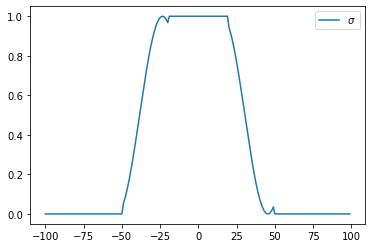

In [88]:
CD1fp = 2.5
CL1fp = CD1fp

CL1sa = 5
CD1sa = 4.55


CD0sa = 0.045
CD0fp = CD0sa

alpha0 = 0.07
alphas = 0.3391428111
a = np.arange(-100,100,1)*np.pi/180                                  # angle d'attaque

deltas = 30.0*np.pi/180                                            # Largeur du stall 
delta0 = np.arange(-15.0,15.01, 5) * np.pi/180                      # Angle des ailerons des ailes
 
k1 = 0.5
k2 = 0.5
k0 = 0.5
S = ([])                                                           # sigma 
for i in a :
    S = np.append(S, compute_sigma(i, alpha0, alphas, deltas))     # Calcul de sigma sur toute la plage d'angle
    
plt.plot(a/np.pi*180 , S, label= r'$\sigma$')
plt.legend()


# test des fonctions sans compter l'angle delta_0 des ailerons
Ces fonctions sont testés pour un delta des ailerons=0, si on veut le changer, changer le paramètres d

In [89]:
d= 0 *180/np.pi                 # angle des ailerons en radian

## Coeff lift

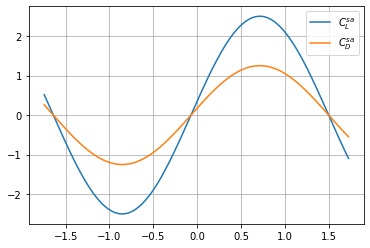

In [90]:
plt.plot(a , CL_sa_function(CL1sa, a, alpha0, k1, d),label=r'$C_L^{sa}$')  
plt.plot(a , CL_fp_function(CD1fp, a, alpha0, k1, d) , label=r'$C_D^{sa}$')     # Ici CD1fp = CLfp dans l'equation j'ai mis CL1fp 
plt.grid()
plt.legend()

## Coeff Drag

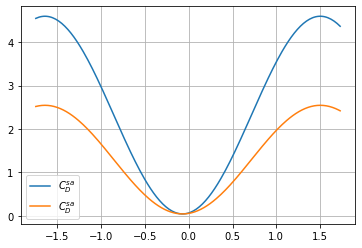

In [91]:
plt.plot(a,CD_sa_function(CD0sa, CD1sa, a, alpha0, d, k0) ,label=r'$C_D^{sa}$')
plt.plot(a , CD_fp_function(CD0fp, CD1fp, a, alpha0) , label=r'$C_D^{sa}$')
plt.grid()
plt.legend()

## Modèle de Cl et Cd complet 

In [92]:
CL = CL_fp_function(CL1fp, a, alpha0, k1, d) + S * (CL_sa_function(CL1sa, a, alpha0, k1, d)\
                                                    -  CL_fp_function(CL1fp, a, alpha0, 1, d))
CD = CD_fp_function(CD0fp, CD1fp, a, alpha0) + S * (CD_sa_function(CD0sa, CD1sa, a, alpha0, d, k0) \
                                                                  -  CD_fp_function(CD0fp, CD1fp, a, alpha0))

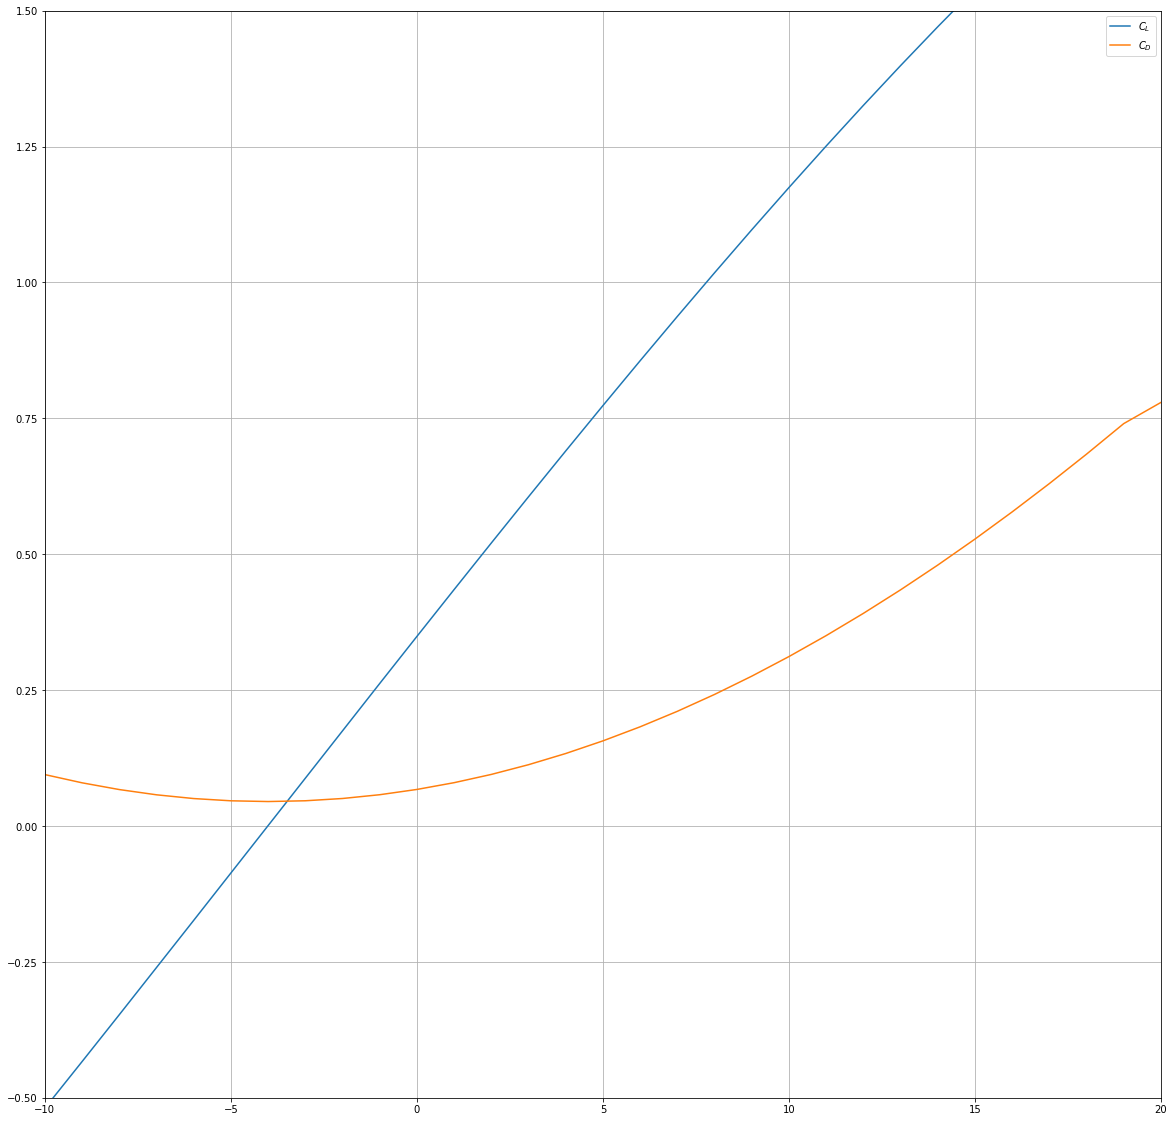

In [93]:
plt.figure(figsize=[20,20])
plt.plot(a / np.pi*180 , CL, label=r'$C_L$')
plt.plot(a  / np.pi*180, CD, label=r'$C_D$')
plt.xlim(-10,20)
plt.ylim(-0.5,1.5)
plt.grid()
plt.legend()

# Ici on prend en compte l'angle delta_0  des ailerons 
## Coeff Lift

In [81]:
for i in delta0 :
    S = ([])                                                           # sigma 
    for j in a : 
        S = np.append(S, compute_sigma(j-(k1*i), alpha0, alphas, deltas))     # Calcul de sigma sur toute la plage d'angle
    
    CL = CL_function(CL1sa, CD1fp, S, a - k1*i, alpha0, i, k1, k2)
    plt.plot(a *180/np.pi, CL, label=r"$\delta$="+str(round(i*180/np.pi)))
plt.grid()
plt.legend()

TypeError: loop of ufunc does not support argument 0 of type float which has no callable sin method

## Coef Drag

In [ ]:
for i in delta0 :
    S = ([])                                                           # sigma 
    for j in a :
        S = np.append(S, compute_sigma(j-(k1*i), alpha0, alphas, deltas))     # Calcul de sigma sur toute la plage d'angle
    CD = CD_function(CD0fp, CD0sa, CD1sa, CD1fp, S, a - k0*i, alpha0, k0)
    plt.plot(a *180/np.pi, CD, label=r"$\delta$="+str(round(i*180/np.pi)))
plt.grid()
plt.legend()